# Interrupted time series with `pymc` models

In [1]:
import arviz as az
import pandas as pd
import pathlib

In [2]:
# %config InlineBackend.figure_format = 'svg'
az.style.use("arviz-darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

## Load data

In [4]:
its_data_path = pathlib.Path.cwd().parents[1] / "causalpy" / "data" / "its.csv"
df = pd.read_csv(its_data_path, parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")

## Run the analysis

In [5]:
from causalpy.pymc_experiments import InterruptedTimeSeries
from causalpy.pymc_models import LinearRegression

result = InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    prediction_model=LinearRegression(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circula

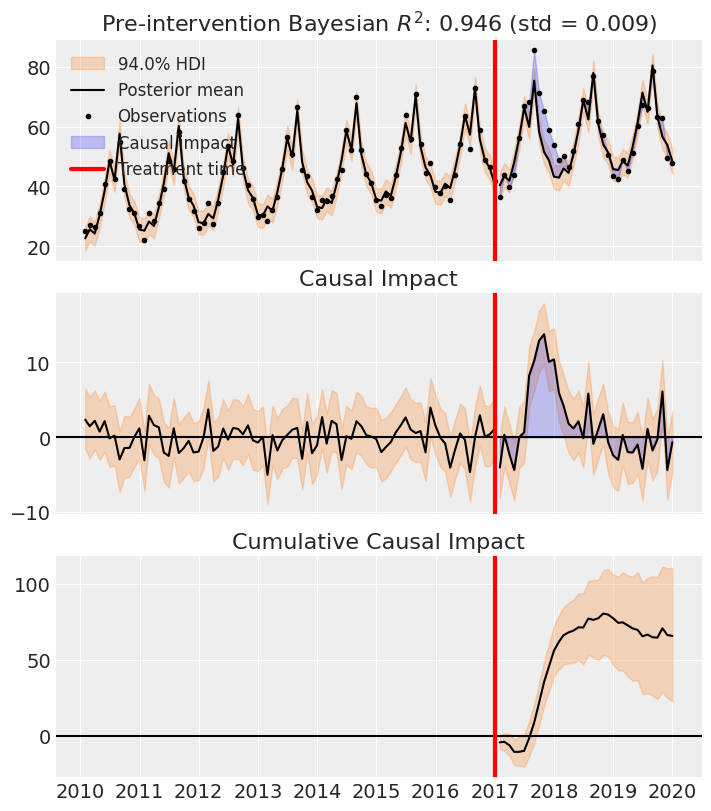

In [6]:
fig, ax = result.plot()

In [7]:
result.summary()

============================Interrupted Time Series=============================
Formula: y ~ 1 + t + C(month)
Model coefficients:
  Intercept                     22.73, 94% HDI [21.21, 24.27]
  C(month)[T.2]                 2.82, 94% HDI [0.91, 4.81]
  C(month)[T.3]                 1.14, 94% HDI [-0.88, 3.13]
  C(month)[T.4]                 7.13, 94% HDI [5.11, 9.08]
  C(month)[T.5]                 15.01, 94% HDI [13.06, 16.98]
  C(month)[T.6]                 24.79, 94% HDI [22.81, 26.74]
  C(month)[T.7]                 18.19, 94% HDI [16.26, 20.20]
  C(month)[T.8]                 33.45, 94% HDI [31.54, 35.40]
  C(month)[T.9]                 16.23, 94% HDI [14.27, 18.33]
  C(month)[T.10]                9.17, 94% HDI [7.24, 11.14]
  C(month)[T.11]                6.26, 94% HDI [4.33, 8.25]
  C(month)[T.12]                0.56, 94% HDI [-1.44, 2.51]
  t                             0.21, 94% HDI [0.19, 0.23]
  sigma                         1.97, 94% HDI [1.70, 2.29]
